## Parte 0
## Tensorflow Básico no modo Eager

Nesse notebook, mostramos detalhes da criação de um modelo de aprendizado utilizando Tensorflow carregando os dados de um arquivo CSV disponível em uma url.

O modo Eager é útil pois permite computar diretamente os comandos conforme são chamados - ao invés do método tradicional que primeiramente cria um grafo como modelo e posteriormente executa tudo em uma sessão.

#### Moacir A. Ponti / 2018

In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe
import os

tf.enable_eager_execution()

Importamos as bibliotecas necessárias. A primeira linha é para melhorar a compatibilidade entre python2 e python3. 

A seguir importamos a biblioteca tensorflow, a biblioteca pandas que permite trabalhar com dataframes e arquivos, e a matplotlib para gerar gráficos

Em seguida usamos o modo "Eager". Esse modo permite que cada operação seja executada imediatamente. Uma vez que o modo eager é acionado ele não pode ser mais desabilitado no mesmo programa.

Vamos exemplificar alguns comandos básicos:

In [54]:
# cria matriz de 1 elemento
A = [[2.]]
print(A)

# cria matriz 2x2
B = tf.constant([[1,2], [3,4]])
print(B)

[[2.0]]
tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [55]:
# realiza multiplicacao matricial
M = tf.matmul(B,B)
print("resultado: {}".format(M))


resultado: [[ 7 10]
 [15 22]]


## Carregando Base de Dados
Iremos carregar uma base de dados no formato CSV, definir o nome de suas features

In [0]:

iris_dataset = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_file = tf.keras.utils.get_file(fname=os.path.basename(iris_dataset),
                                           origin=iris_dataset)

# definindo o nome das colunas, com as features e a última coluna sendo o rótulo
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']



In [27]:
# visualiza as 5 primeiras linhas do CSV
!head -n5 {train_dataset_file}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [0]:
# separamos features dos labels para facilitar o treinamento
feature_names = column_names[:-1]
label_name = column_names[-1]

Para criar o dataset Tensorflow a partir do CSV, temos que definir o tamanho do *minibatch* (exemplos a serem carregados em cada iteração no treinamento), o número de *épocas (epoch)* que define quantos exemplos serão utilizados no processo de treinamento (1 época significa que cada exemplo será visto 1 vez), bem como outras informações

In [0]:
batch_size = 16

train_dataset = tf.contrib.data.make_csv_dataset( train_dataset_file, 
                                                  batch_size, 
                                                  column_names=column_names, 
                                                  label_name=label_name, 
                                                  num_epochs=1 )

In [30]:
# podemos obter um batch usando o metodo next(iter())
features, labels = next(iter(train_dataset))

# como obtemos direto do Tensorflow Dataset, esses não são arrays
# erro abaixo:
print(features[:5]) 

TypeError: ignored

In [31]:
features

OrderedDict([('sepal_length',
              <tf.Tensor: id=267382, shape=(16,), dtype=float32, numpy=
              array([5.1, 7.7, 6.6, 6.5, 6.3, 5. , 5.8, 5.1, 4.7, 4.4, 6.9, 5.8, 7.2,
                     4.8, 6.8, 4.5], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=267383, shape=(16,), dtype=float32, numpy=
              array([3.5, 3. , 2.9, 3.2, 3.4, 3.4, 2.7, 3.8, 3.2, 3.2, 3.1, 2.6, 3.6,
                     3.1, 3.2, 2.3], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=267380, shape=(16,), dtype=float32, numpy=
              array([1.4, 6.1, 4.6, 5.1, 5.6, 1.5, 4.1, 1.9, 1.6, 1.3, 5.1, 4. , 6.1,
                     1.6, 5.9, 1.3], dtype=float32)>),
             ('petal_width',
              <tf.Tensor: id=267381, shape=(16,), dtype=float32, numpy=
              array([0.3, 2.3, 1.3, 2. , 2.4, 0.2, 1. , 0.4, 0.2, 0.2, 2.3, 1.2, 2.5,
                     0.2, 2.3, 0.3], dtype=float32)>)])

In [32]:
labels

<tf.Tensor: id=267384, shape=(16,), dtype=int32, numpy=array([0, 2, 1, 2, 2, 0, 1, 0, 0, 0, 2, 1, 2, 0, 2, 0], dtype=int32)>

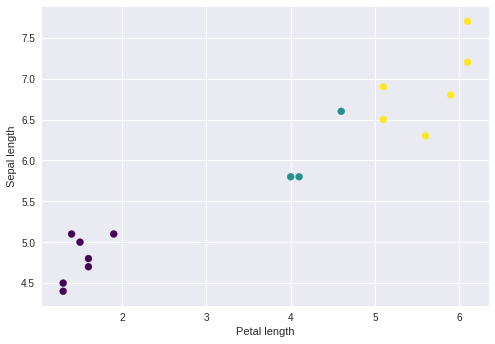

In [34]:
# apesar disso podemos visualizar com matplotlib
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length");

In [0]:
# definindo uma funcao para tomar valores de uma lista de tensores e criar um tensor combinado
# reempacota o dicionario de features em um unico array
def pack_features_vector(features, labels):
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [0]:
train_dataset = train_dataset.map(pack_features_vector)

In [38]:
# depois de empilhar no formato de lista, podemos utilizar o tensor como array
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[5.  3.5 1.3 0.3]
 [4.9 2.4 3.3 1. ]
 [5.  3.3 1.4 0.2]
 [5.1 3.7 1.5 0.4]
 [6.3 3.4 5.6 2.4]], shape=(5, 4), dtype=float32)


## Criação do modelo de aprendizado

O Keras faz parte do Tensorflow e facilita muito a definição de arquiteturas de sistemas de aprendizado. Abaixo iremos utilizar uma rede neural Perceptron Multicamadas com 2 camadas ocultas (com 16 e 8 neurônios)

Utilizamos também o método *Dropout* para regularizar o processo de treinamento

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, activation="relu", input_shape=(4,)),  # input shape required
  #tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(8, activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(3)
])

In [42]:
# no modo Eager podemos tentar usar o modelo para obter predições
# mas inicialmente o modelo tem valores aleatórios
predictions = model(features)
predictions[:5]

<tf.Tensor: id=267568, shape=(5, 3), dtype=float32, numpy=
array([[-1.3192303, -2.2898605, -1.4294093],
       [-1.2035236, -2.110058 , -1.538749 ],
       [-1.2855179, -2.2318919, -1.4012935],
       [-1.3695681, -2.3780537, -1.5023085],
       [-1.8431604, -3.2861714, -2.3192124]], dtype=float32)>

In [43]:
# em cima da saída podemos aplicar uma função softmax para obter probabilidades
predictions = tf.nn.softmax(predictions)
predictions

<tf.Tensor: id=267570, shape=(16, 3), dtype=float32, numpy=
array([[0.43965358, 0.16656022, 0.39378622],
       [0.47189873, 0.1906101 , 0.3374911 ],
       [0.4388234 , 0.17032751, 0.39084905],
       [0.4463362 , 0.16281049, 0.39085323],
       [0.5383735 , 0.12717211, 0.33445436],
       [0.5314594 , 0.13282202, 0.3357186 ],
       [0.51446426, 0.14821814, 0.33731765],
       [0.44612795, 0.16042958, 0.39344248],
       [0.44694597, 0.15611224, 0.39694184],
       [0.504785  , 0.15966003, 0.335555  ],
       [0.45398468, 0.15306184, 0.3929535 ],
       [0.53450435, 0.13068375, 0.33481187],
       [0.43899366, 0.17924884, 0.38175753],
       [0.4422106 , 0.15748955, 0.40029982],
       [0.5009666 , 0.16512038, 0.33391303],
       [0.43577796, 0.17704512, 0.3871769 ]], dtype=float32)>

O modelo ainda não foi treinado então as predições serão ainda arbitrárias conforme podemos visualizar abaixo

In [45]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [0 1 0 0 2 2 2 0 0 2 0 2 0 0 1 0]


### Definição do método de Otimização
Utilizamos o gradiente para otimizar, para isso precisamos de uma função de custo

Aqui exemplifico uma forma de utilizar as funções de erro médio quadrático e de entropia cruzada

Depois definimos uma função grad para calcular o gradiente e a função de custo, retornando ambas

In [46]:
def loss(model, x, y, type="CE"):
  if type=="CE":
    y_ = model(x)
    l = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)
  elif type == "MSE":
    y_ = tf.argmax(model(x), axis=1, output_type=tf.int32)
    l = tf.losses.mean_squared_error(labels=y, predictions=y_)
    
  return l


lmse = loss(model, features, labels, type="MSE")
lce = loss(model, features, labels)
print("MSE Loss test: {}".format(lmse))
print("CE Loss test: {}".format(lce))

MSE Loss test: 1.375
CE Loss test: 1.0151474475860596


In [0]:
def grad(model, inputs, targets, type="CE"):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, type=type)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
# Agora o método de otimização é definido, e sua taxa de aprendizado

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
global_step = tf.train.get_or_create_global_step()

In [48]:
# Vamos testar o gradiente e valor da função de custo iniciais
loss_value, grads = grad(model, features, labels, type="CE")

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 2009, Initial Loss: 1.0151474475860596
Step: 2010,         Loss: 1.0148566961288452


### Processo de Treinamento
Vamos agora iterar, obtendo dados em batches e aplicando o método do gradiente.

Aproveitando, iremos calcular a média do custo e a acurácia

In [50]:
train_loss_results =[]
train_accuracy_results = []

num_epochs = 301

for epoch in range(num_epochs):
  ep_loss_avg = tfe.metrics.Mean()
  ep_acc = tfe.metrics.Accuracy()
  
  # laco de treinamento utilizando batches
  for x,y in train_dataset:
    # realiza um passo de otimizacao do modelo
    loss_value, grads = grad(model,x,y)
    optimizer.apply_gradients(zip(grads,model.variables), global_step)
    
    # computa metricas para acompanhar progresso
    ep_loss_avg(loss_value) # loss
    ep_acc(tf.argmax(model(x),axis=1, output_type=tf.int32), y) # acuracia de treinamento
  
  # armazena resultados ao fim de cada epoca
  train_loss_results.append(ep_loss_avg.result())
  train_accuracy_results.append(ep_acc.result())
  
  if epoch % 25 == 0:
    print("Epoch {:03d}; Loss: {:.3f}; Accuracy: {:.3%}".format(epoch,ep_loss_avg.result(),ep_acc.result()))

Epoch 000; Loss: 0.836; Accuracy: 81.667%
Epoch 025; Loss: 0.780; Accuracy: 89.167%
Epoch 050; Loss: 0.710; Accuracy: 90.000%
Epoch 075; Loss: 0.642; Accuracy: 90.000%
Epoch 100; Loss: 0.578; Accuracy: 91.667%
Epoch 125; Loss: 0.518; Accuracy: 91.667%
Epoch 150; Loss: 0.456; Accuracy: 93.333%
Epoch 175; Loss: 0.428; Accuracy: 93.333%
Epoch 200; Loss: 0.402; Accuracy: 95.833%
Epoch 225; Loss: 0.375; Accuracy: 95.833%
Epoch 250; Loss: 0.351; Accuracy: 95.000%
Epoch 275; Loss: 0.329; Accuracy: 95.000%
Epoch 300; Loss: 0.310; Accuracy: 95.833%


## Teste do modelo

Após treinar, vamos agora verificar se o modelo é adequado para exemplos não vistos no treinamento

In [0]:
irisdataset_test = "http://download.tensorflow.org/data/iris_test.csv"

test_dataset_file = tf.keras.utils.get_file(fname=os.path.basename(irisdataset_test),
                                  origin=irisdataset_test)

In [0]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_dataset_file,
    batch_size, 
    column_names=column_names,
    label_name='label',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [53]:
# calculamos a acurácia do Teste
test_acc = tfe.metrics.Accuracy()

for (x,y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_acc(prediction, y)
  
print("Test set accuracy: {:.3%}".format(test_acc.result()))

Test set accuracy: 93.333%


## Exercícios

Tente utilizar outra base de dados, e modifique a arquitetura e seus parâmetros de forma a obter uma boa acurácia.